In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')

import pandas
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

In [2]:
# Memuat data
data = pandas.read_csv(f'dataset.csv')
data.columns = ('text','language')
data

,text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


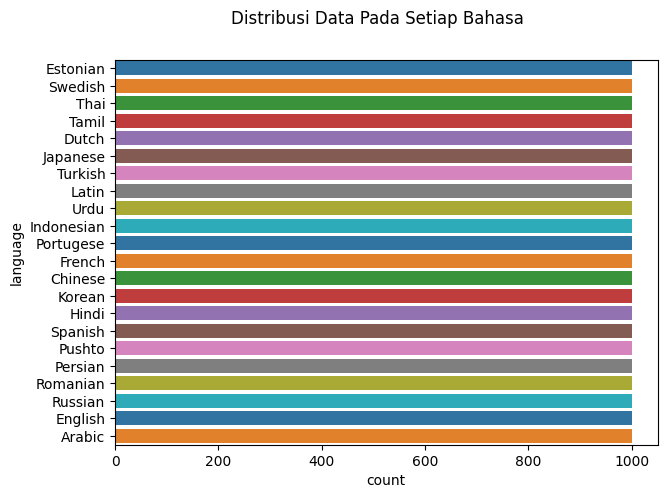

In [3]:
# Distribusi Data Pada Setiap Bahasa
plt.figure(figsize=(7,5))
sns.countplot(y="language",data=data,palette="tab10")
plt.suptitle('Distribusi Data Pada Setiap Bahasa')
plt.show()

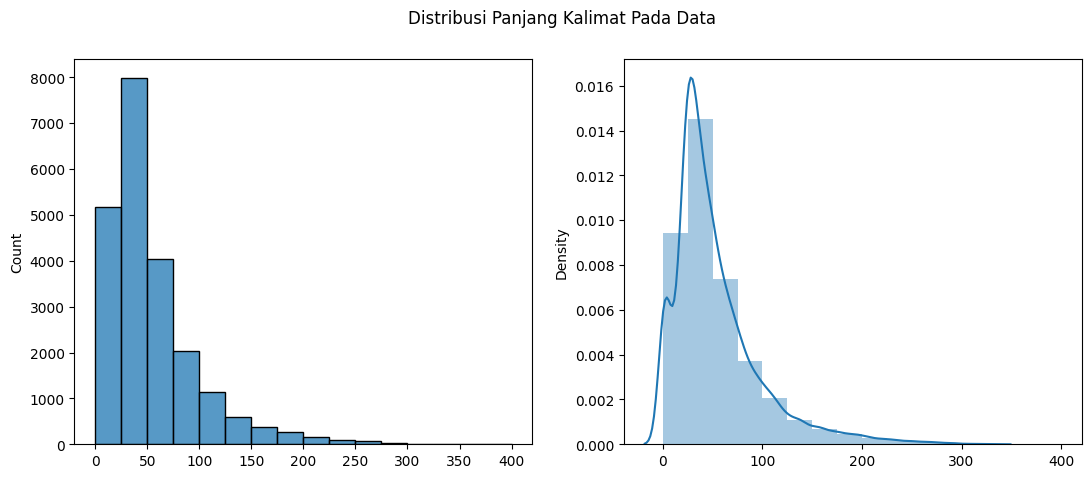

In [4]:
# Distribusi Panjang Kalimat Pada Data
sent_lengths = [len(text.split()) for text in data.text.values]
plt.subplots(1,2,figsize=(13,5))
plt.suptitle('Distribusi Panjang Kalimat Pada Data')
bins=[0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400]
plt.subplot(1,2,1)
sns.histplot(sent_lengths, bins=bins)
plt.subplot(1,2,2)
sns.distplot(sent_lengths, bins=bins)
plt.show()

In [5]:
# Pembersihan Teks
def clean_txt(text):
    text=text.lower()
    text=re.sub(r'[^\w\s]',' ',text)
    text=re.sub(r'[_0-9]',' ',text)
    text=re.sub(r'\s\s+',' ',text)
    return text

# Penerapan Function clean_txt
txt = 'Saya (&*(()))mencuci tangan $agar #terhindar dari$ kuman'
print(clean_txt(txt))

saya mencuci tangan agar terhindar dari kuman


In [6]:
# Pemisahan Data Latih dan Uji
x_train, x_test, y_train, y_test = train_test_split(data.text.values, data.language.values, test_size=0.1, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19800,), (19800,), (2200,), (2200,))

In [7]:
# Vektorisasi
x_train = [clean_txt(text) for text in tqdm(x_train)]
x_test = [clean_txt(text) for text in tqdm(x_test)]

# Tfidf Vectorizer
tfidf = TfidfVectorizer()
tfidf.fit(x_train)

x_train_ready = tfidf.transform(x_train)
x_test_ready = tfidf.transform(x_test)

# x_train_ready,x_test_ready

100%|██████████| 2200/2200 [00:00<00:00, 43234.37it/s]


In [8]:
# Label Encoding
enc = LabelEncoder()
enc.fit(y_train)
y_train_ready = enc.transform(y_train)
y_test_ready = enc.transform(y_test)
labels = enc.classes_

# Pengujian Encoder
preds = enc.inverse_transform([0,3,6])
preds

array(['Arabic', 'English', 'Hindi'], dtype=object)

In [9]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(x_train_ready,y_train_ready)

# Pipeline untuk menggabungkan vektorizer dan model terlatih menjadi satu objek
model = Pipeline([('vectorizer',tfidf),('nb',nb)])

In [10]:
# Function untuk melakukan prediksi bahasa dari kalimat teks
def predict(text):
    pred = model.predict([clean_txt(text)])
    ans = enc.inverse_transform(pred)
    return ans[0]

example_text = ['Saya mencuci tangan agar terhindar dari kuman',
                'I wash my hands to avoid germs',
                'أغسل يدي لتجنب الجراثيم',
                'Ik was mijn handen om ziektekiemen te voorkomen',
                'कीटाणुओं से बचने के लिए मैं अपने हाथ धोता हूं',
                'Me lavo las manos para evitar gérmenes']
result_language = []

for text in example_text:
  result_language.append(predict(text))

for language in result_language:
  print(language)

Indonesian
English
Arabic
Dutch
Hindi
Spanish


In [11]:
# Data Uji / Data Test
y_text = ['Saya menanam pohon mangga bersama ayah', "I planted a mango tree with my father",
          'Ik heb samen met mijn vader een mangoboom geplant', 'لقد زرعت شجرة مانجو مع والدي',
          "J'ai planté un manguier avec mon père", 'Plantei uma mangueira com meu pai',
          'Planté un árbol de mango con mi padre.', '父と一緒にマンゴーの木を植えました', 'Я посадил манговое дерево со своим отцом',
          'मैंने अपने पिता के साथ एक आम का पेड़ लगाया', 'میں نے اپنے والد کے ساتھ آم کا درخت لگایا', 'من با پدرم یه درخت انبه کاشتم',
          'ما د خپل پلار سره د آمو ونه کرله', '아버지와 함께 망고나무를 심었어요', 'அப்பாவோடு சேர்ந்து மாமரம் நட்டேன்',
          'Babamla birlikte mango ağacı diktim', 'Istutasin koos isaga mangopuu', 'Am plantat un mango cu tatăl meu',
          '我和父亲一起种了一棵芒果树', 'Jag planterade ett mangoträd med min pappa', 'Ego plantavi mango arborem cum patre meo',
          'ฉันปลูกต้นมะม่วงกับพ่อ', 'Kakak saya pergi ke sekolah dengan sepeda' , 'My brother goes to school by bicycle',
          'Mijn zus gaat met de fiets naar school', 'أختي تذهب إلى المدرسة بالدراجة', "Ma sœur va à l'école à vélo",
          "Meu irmão vai para a escola de bicicleta", "Mi hermano va al colegio en bicicleta", "私の兄は自転車で学校に行きます",
          "Мой брат ездит в школу на велосипеде", "मेरा भाई साइकिल से स्कूल जाता है", "میرا بھائی سائیکل پر سکول جاتا ہے۔",
          "برادرم با دوچرخه به مدرسه می رود", "زما ورور په بایسکل ښوونځي ته ځي", "내 동생은 자전거로 학교에 가요",
          "அண்ணன் சைக்கிளில் பள்ளிக்குச் செல்கிறான்", "Kardeşim okula bisikletle gidiyor", "Mu vend käib koolis jalgrattaga",
          "Fratele meu merge la școală cu bicicleta", "我弟弟骑自行车去上学", "Min bror går till skolan med cykel",
          "Frater meus ad scholam per birotam venit", "ฉันซื้อดอกไม้ให้แม่"]
y_true_collect = ['Indonesian', 'English', 'Dutch', 'Arabic', 'French', 'Portugese', 'Spanish', 'Japanese', 'Russian', 'Hindi', 'Urdu',
          'Persian', 'Pushto', 'Korean', 'Tamil', 'Turkish', 'Estonian', 'Romanian', 'Chinese', 'Swedish', 'Latin', 'Thai',
          'Indonesian', 'English', 'Dutch', 'Arabic', 'French', 'Portugese', 'Spanish', 'Japanese', 'Russian', 'Hindi', 'Urdu',
          'Persian', 'Pushto', 'Korean', 'Tamil', 'Turkish', 'Estonian', 'Romanian', 'Chinese', 'Swedish', 'Latin', 'Thai']
y_true_real = []


for collect in y_true_collect:
  collect_result = np.where(labels == collect)[0][0]
  y_true_real.append(collect_result)

# Data Prediksi
y_pred_lang = []
y_pred_real = []
for text in y_text:
  text_result = np.where(labels == predict(text))[0][0]
  y_pred_lang.append(predict(text))
  y_pred_real.append(text_result)

# Pembersihan Data Uji dan Test
y_true = []
y_true = [1 for i in range(len(y_true_real))]

y_pred = []
y_pred_check = np.isclose(y_true_real, y_pred_real)
for pred in y_pred_check:
  if pred == True:
    y_pred.append(1)
  else:
    y_pred.append(0)

print("Data Uji : ")
print(pandas.value_counts(y_pred_lang))

Data Uji : 
Swedish       7
Indonesian    2
English       2
Latin         2
Romanian      2
Estonian      2
Tamil         2
Korean        2
Pushto        2
Persian       2
Urdu          2
Hindi         2
Russian       2
Spanish       2
Portugese     2
French        2
Arabic        2
Dutch         2
Thai          2
Turkish       1
dtype: int64


In [12]:
# Mean Square Error
mse = mean_squared_error(y_true, y_pred)
mse

0.11363636363636363

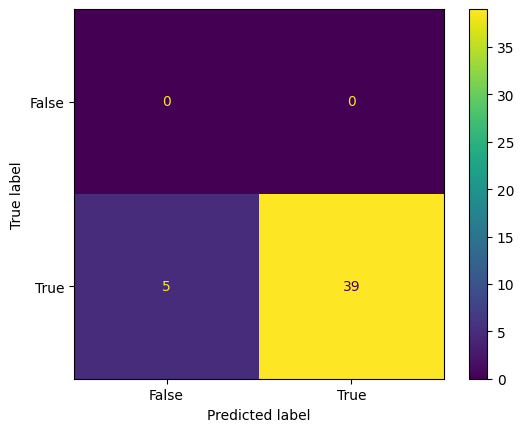

[[ 0  0]
 [ 5 39]]


In [13]:
# Confusion Matrix / Matriks Pengujian
cm = confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()
print(cm)

In [14]:
# Metrik Kinerja
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Akurasi:", accuracy)
print("Presisi:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Akurasi: 0.8863636363636364
Presisi: 1.0
Recall: 0.8863636363636364
F1 Score: 0.9397590361445783
